<a href="https://colab.research.google.com/github/jai2shan/TSAI-EVA40-Assignments/blob/master/Session%2010/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone https://github.com/jai2shan/TSAI-EVA40-Assignments.git
import os
os.chdir(r'/content/TSAI-EVA40-Assignments/Session 10/asgnmt10')

In [2]:
from torchvision import transforms
from DataLoader import cifar_data_loader,View_images
from cutout import *
import torch
from torchsummary import summary
from resnet import ResNet18

from LR_Finder import *
from Training_Testing import TrainTest
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from ModelPerformance import *
from gradcam import GradCamDisplay
import PIL
from gradcam import *
import copy
import pandas as pd

In [3]:
trainloader,testloader = cifar_data_loader(BatchSize=250)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = ResNet18().to(device)
summary(net, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,


Learning rate search finished. See the graph with {finder_name}.plot()


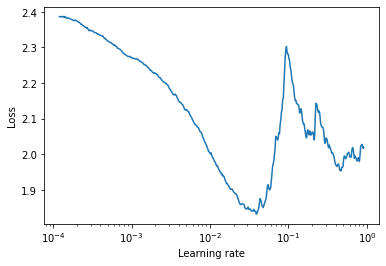

In [5]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

lr_finder = LRFinder(net, optimizer, criterion)
lr_finder.range_test(trainloader, end_lr=1, num_iter=500,step_mode="exp")
lr_finder.plot()


In [6]:
lr_ = pd.DataFrame(lr_finder.history)
lr_max = lr_.loc[lr_['loss']==lr_['loss'].min(),'lr'].values[0]

In [7]:
net = ResNet18().to(device)
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr_max, momentum=0.9,weight_decay = 0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

for epoch in range(50):
    print("EPOCH:", epoch)
    tt.train_(net, device, trainloader, optimizer, criterion, epoch,L1 = False)
    acc = tt.test_(net, device, testloader)  
    scheduler.step(tt.test_losses[epoch])
       
print('Finished Training')

  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.5140000581741333 Batch_id=199 Accuracy=35.42: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -2.6588, Accuracy: 4667/10000 (46.67%)

EPOCH: 1


Loss=1.1032932996749878 Batch_id=199 Accuracy=50.79: 100%|██████████| 200/200 [00:37<00:00,  5.35it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.3321, Accuracy: 5873/10000 (58.73%)

EPOCH: 2


Loss=1.0869224071502686 Batch_id=199 Accuracy=59.04: 100%|██████████| 200/200 [00:37<00:00,  5.35it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.9192, Accuracy: 6625/10000 (66.25%)

EPOCH: 3


Loss=0.9093353152275085 Batch_id=199 Accuracy=64.72: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.8395, Accuracy: 7126/10000 (71.26%)

EPOCH: 4


Loss=0.8648321628570557 Batch_id=199 Accuracy=68.34: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.9449, Accuracy: 7369/10000 (73.69%)

EPOCH: 5


Loss=0.7693361639976501 Batch_id=199 Accuracy=70.58: 100%|██████████| 200/200 [00:37<00:00,  5.32it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.6213, Accuracy: 7814/10000 (78.14%)

EPOCH: 6


Loss=0.7499411106109619 Batch_id=199 Accuracy=73.11: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.9748, Accuracy: 7860/10000 (78.60%)

EPOCH: 7


Loss=0.7262531518936157 Batch_id=199 Accuracy=74.27: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.4310, Accuracy: 8078/10000 (80.78%)

EPOCH: 8


Loss=0.7069616913795471 Batch_id=199 Accuracy=75.89: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.7238, Accuracy: 8102/10000 (81.02%)

EPOCH: 9


Loss=0.7008508443832397 Batch_id=199 Accuracy=76.80: 100%|██████████| 200/200 [00:37<00:00,  5.35it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.1117, Accuracy: 7877/10000 (78.77%)

EPOCH: 10


Loss=0.6834415197372437 Batch_id=199 Accuracy=77.46: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.6920, Accuracy: 8097/10000 (80.97%)

EPOCH: 11


Loss=0.611605703830719 Batch_id=199 Accuracy=78.81: 100%|██████████| 200/200 [00:37<00:00,  5.35it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.3770, Accuracy: 8308/10000 (83.08%)

EPOCH: 12


Loss=0.5305014252662659 Batch_id=199 Accuracy=79.34: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.4055, Accuracy: 8362/10000 (83.62%)

EPOCH: 13


Loss=0.48941123485565186 Batch_id=199 Accuracy=79.89: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.8014, Accuracy: 8311/10000 (83.11%)

EPOCH: 14


Loss=0.5496522784233093 Batch_id=199 Accuracy=80.57: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.4523, Accuracy: 8488/10000 (84.88%)

EPOCH: 15


Loss=0.5798273086547852 Batch_id=199 Accuracy=81.01: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.6298, Accuracy: 8614/10000 (86.14%)

EPOCH: 16


Loss=0.5302810072898865 Batch_id=199 Accuracy=81.93: 100%|██████████| 200/200 [00:37<00:00,  5.31it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3271, Accuracy: 8497/10000 (84.97%)

EPOCH: 17


Loss=0.38290268182754517 Batch_id=199 Accuracy=82.35: 100%|██████████| 200/200 [00:37<00:00,  5.31it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0163, Accuracy: 8651/10000 (86.51%)

EPOCH: 18


Loss=0.531171441078186 Batch_id=199 Accuracy=82.78: 100%|██████████| 200/200 [00:37<00:00,  5.32it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.2006, Accuracy: 8640/10000 (86.40%)

EPOCH: 19


Loss=0.5011371970176697 Batch_id=199 Accuracy=83.28: 100%|██████████| 200/200 [00:37<00:00,  5.28it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0550, Accuracy: 8637/10000 (86.37%)

EPOCH: 20


Loss=0.47010985016822815 Batch_id=199 Accuracy=83.46: 100%|██████████| 200/200 [00:37<00:00,  5.31it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.2243, Accuracy: 8691/10000 (86.91%)

EPOCH: 21


Loss=0.42824479937553406 Batch_id=199 Accuracy=83.74: 100%|██████████| 200/200 [00:37<00:00,  5.29it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.6901, Accuracy: 8626/10000 (86.26%)

EPOCH: 22


Loss=0.4801137149333954 Batch_id=199 Accuracy=83.84: 100%|██████████| 200/200 [00:38<00:00,  5.21it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.9230, Accuracy: 8656/10000 (86.56%)

Epoch    23: reducing learning rate of group 0 to 3.8831e-03.
EPOCH: 23


Loss=0.3601551651954651 Batch_id=199 Accuracy=87.69: 100%|██████████| 200/200 [00:37<00:00,  5.32it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.6803, Accuracy: 9076/10000 (90.76%)

EPOCH: 24


Loss=0.3185115456581116 Batch_id=199 Accuracy=88.80: 100%|██████████| 200/200 [00:37<00:00,  5.30it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.8972, Accuracy: 9102/10000 (91.02%)

EPOCH: 25


Loss=0.2950349748134613 Batch_id=199 Accuracy=89.38: 100%|██████████| 200/200 [00:37<00:00,  5.31it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.0648, Accuracy: 9114/10000 (91.14%)

EPOCH: 26


Loss=0.34979385137557983 Batch_id=199 Accuracy=89.68: 100%|██████████| 200/200 [00:37<00:00,  5.29it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.3090, Accuracy: 9140/10000 (91.40%)

EPOCH: 27


Loss=0.2418425977230072 Batch_id=199 Accuracy=89.93: 100%|██████████| 200/200 [00:37<00:00,  5.31it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.2725, Accuracy: 9131/10000 (91.31%)

EPOCH: 28


Loss=0.31888434290885925 Batch_id=199 Accuracy=90.33: 100%|██████████| 200/200 [00:37<00:00,  5.29it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.4992, Accuracy: 9151/10000 (91.51%)

EPOCH: 29


Loss=0.33476147055625916 Batch_id=199 Accuracy=90.54: 100%|██████████| 200/200 [00:37<00:00,  5.35it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.5108, Accuracy: 9157/10000 (91.57%)

EPOCH: 30


Loss=0.21623371541500092 Batch_id=199 Accuracy=90.54: 100%|██████████| 200/200 [00:37<00:00,  5.33it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.6608, Accuracy: 9173/10000 (91.73%)

EPOCH: 31


Loss=0.275271475315094 Batch_id=199 Accuracy=90.71: 100%|██████████| 200/200 [00:37<00:00,  5.32it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.7837, Accuracy: 9165/10000 (91.65%)

EPOCH: 32


Loss=0.31359758973121643 Batch_id=199 Accuracy=91.10: 100%|██████████| 200/200 [00:37<00:00,  5.32it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.7859, Accuracy: 9165/10000 (91.65%)

EPOCH: 33


Loss=0.27039194107055664 Batch_id=199 Accuracy=91.12: 100%|██████████| 200/200 [00:37<00:00,  5.30it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.9071, Accuracy: 9198/10000 (91.98%)

EPOCH: 34


Loss=0.2915729284286499 Batch_id=199 Accuracy=91.33: 100%|██████████| 200/200 [00:37<00:00,  5.30it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.8940, Accuracy: 9195/10000 (91.95%)

EPOCH: 35


Loss=0.22347131371498108 Batch_id=199 Accuracy=91.24: 100%|██████████| 200/200 [00:37<00:00,  5.30it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.9061, Accuracy: 9192/10000 (91.92%)

EPOCH: 36


Loss=0.25557833909988403 Batch_id=199 Accuracy=91.60: 100%|██████████| 200/200 [00:37<00:00,  5.33it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.0086, Accuracy: 9228/10000 (92.28%)

EPOCH: 37


Loss=0.16887475550174713 Batch_id=199 Accuracy=91.54: 100%|██████████| 200/200 [00:37<00:00,  5.32it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.0360, Accuracy: 9236/10000 (92.36%)

EPOCH: 38


Loss=0.24101625382900238 Batch_id=199 Accuracy=91.70: 100%|██████████| 200/200 [00:37<00:00,  5.33it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.1779, Accuracy: 9203/10000 (92.03%)

EPOCH: 39


Loss=0.21926110982894897 Batch_id=199 Accuracy=92.09: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.0822, Accuracy: 9193/10000 (91.93%)

EPOCH: 40


Loss=0.21500594913959503 Batch_id=199 Accuracy=92.06: 100%|██████████| 200/200 [00:37<00:00,  5.33it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.1176, Accuracy: 9219/10000 (92.19%)

EPOCH: 41


Loss=0.2001432627439499 Batch_id=199 Accuracy=92.22: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.2101, Accuracy: 9231/10000 (92.31%)

EPOCH: 42


Loss=0.18497441709041595 Batch_id=199 Accuracy=92.51: 100%|██████████| 200/200 [00:37<00:00,  5.35it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.0819, Accuracy: 9227/10000 (92.27%)

EPOCH: 43


Loss=0.20303751528263092 Batch_id=199 Accuracy=92.57: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.2285, Accuracy: 9211/10000 (92.11%)

EPOCH: 44


Loss=0.24624353647232056 Batch_id=199 Accuracy=92.34: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.3410, Accuracy: 9223/10000 (92.23%)

EPOCH: 45


Loss=0.2525416612625122 Batch_id=199 Accuracy=92.56: 100%|██████████| 200/200 [00:37<00:00,  5.34it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.4279, Accuracy: 9252/10000 (92.52%)

EPOCH: 46


Loss=0.20620855689048767 Batch_id=199 Accuracy=92.65: 100%|██████████| 200/200 [00:37<00:00,  5.27it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.4338, Accuracy: 9208/10000 (92.08%)

EPOCH: 47


Loss=0.2037988156080246 Batch_id=199 Accuracy=92.92: 100%|██████████| 200/200 [00:37<00:00,  5.35it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.4733, Accuracy: 9253/10000 (92.53%)

EPOCH: 48


Loss=0.20407816767692566 Batch_id=199 Accuracy=92.93: 100%|██████████| 200/200 [00:37<00:00,  5.33it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.4481, Accuracy: 9221/10000 (92.21%)

EPOCH: 49


Loss=0.17024178802967072 Batch_id=199 Accuracy=92.91: 100%|██████████| 200/200 [00:37<00:00,  5.32it/s]



Test set: Average loss: -11.3369, Accuracy: 9238/10000 (92.38%)

Finished Training


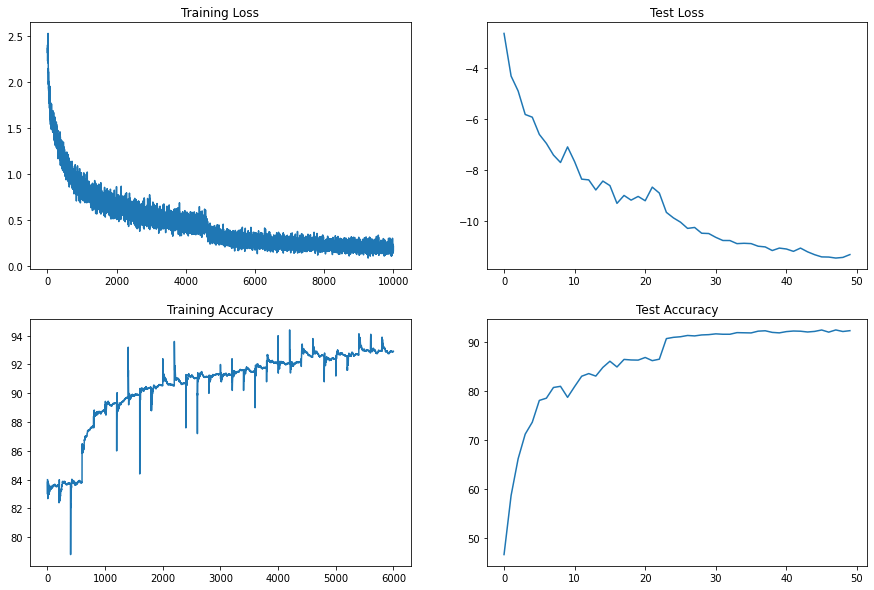

In [8]:
PlotTrainingGraphs(tt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


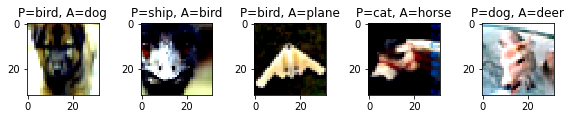

In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Misclassification(testloader,net,classes,device)

In [10]:
from gradcam import GradCamDisplay
import PIL
img_name =['airplane.png','automobile.png','bird.png','cat.png','deer.png']

pil_image = []
for i,img in enumerate(img_name):
   pil_image.append(PIL.Image.open(img))

FileNotFoundError: ignored

In [ ]:
from pylab import *
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4],padding=1))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
images[:4]